In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Convolution2D, MaxPooling2D, Activation, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.1


In [2]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [3]:
K.image_data_format()

'channels_last'

In [4]:
class_names = ["cat", "dog"]
batch_size = 128 # 32 # 64 # 128
image_shape = (299, 299, 3)

In [5]:
X_train = np.load("X_train.npy")
X_valid = np.load("X_valid.npy")
X_test = np.load("X_test.npy")

y_train = np.load("y_train.npy")
y_valid = np.load("y_valid.npy")
y_test = np.load("y_test.npy")

In [6]:
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [7]:
# X_train = X_train[:1000]
# X_valid = X_valid[:500]
# X_test = X_test[:300]

# y_train = y_train[:1000]
# y_valid = y_valid[:500]
# y_test = y_test[:300]

In [8]:
print("X_train.shape:", str(X_train.shape))
print("X_valid.shape:", str(X_valid.shape))
print("X_test.shape:", str(X_test.shape))
print()
print("y_train.shape:", str(y_train.shape))
print("y_valid.shape:", str(y_valid.shape))
print("y_test.shape:", str(y_test.shape))

X_train.shape: (17462, 299, 299, 3)
X_valid.shape: (3742, 299, 299, 3)
X_test.shape: (3742, 299, 299, 3)

y_train.shape: (17462, 1)
y_valid.shape: (3742, 1)
y_test.shape: (3742, 1)


In [9]:
y_train = to_categorical(y_train, len(class_names))
y_valid = to_categorical(y_valid, len(class_names))
y_test = to_categorical(y_test, len(class_names))

In [10]:
print("y_train.shape:", str(y_train.shape))
print("y_valid.shape:", str(y_valid.shape))
print("y_test.shape:", str(y_test.shape))

y_train.shape: (17462, 2)
y_valid.shape: (3742, 2)
y_test.shape: (3742, 2)


In [11]:
# %%time

# datagen_aug = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     horizontal_flip=True,
#     zoom_range=0.15,
#     rescale=1./255
#     )
# datagen = ImageDataGenerator(rescale=1./255)

# train_generator = datagen_aug.flow(X_train, y_train, batch_size=batch_size)
# # valid_generator = datagen.flow(X_valid, y_valid, batch_size=batch_size)
# # test_generator = datagen.flow(X_test, y_test, batch_size=batch_size)


In [12]:
def make_model():
    inputs = Input(shape=image_shape, name="Input")
    base_model = InceptionResNetV2(include_top=False, 
                               input_shape=image_shape, 
                               input_tensor=inputs, 
                               weights='imagenet', 
                               classes=2)
    base_model.trainable = False
    batch_norm1 = BatchNormalization()(base_model.output)
    flat1 = Flatten()(batch_norm1)
    dense1 = Dense(100, activation="relu")(flat1)
    dense2 = Dense(len(class_names), activation="softmax")(dense1)

    model = Model(inputs=[inputs], outputs=[dense2])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [13]:
%%time
K.clear_session()

model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

conv2d_117 (Conv2D)             (None, 17, 17, 128)  139264      block17_10_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 17, 17, 128)  384         conv2d_117[0][0]                 
__________________________________________________________________________________________________
activation_117 (Activation)     (None, 17, 17, 128)  0           batch_normalization_117[0][0]    
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 17, 17, 160)  143360      activation_117[0][0]             
__________________________________________________________________________________________________
batch_normalization_118 (BatchN (None, 17, 17, 160)  480         conv2d_118[0][0]                 
__________________________________________________________________________________________________
activation

Total params: 64,173,582
Trainable params: 9,833,774
Non-trainable params: 54,339,808
__________________________________________________________________________________________________
CPU times: user 14.8 s, sys: 2.14 s, total: 16.9 s
Wall time: 15.8 s


In [14]:
# plot_model(model, to_file='model.png')

In [15]:
checkpoint = ModelCheckpoint('cat_dogs_with_InceptionResNetV2.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=1,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-6, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [16]:
%%time

# history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
#                    epochs = 999999999999,
#                    validation_data=(X_valid, y_valid),
#                    steps_per_epoch=X_train.shape[0] // batch_size,
#                    verbose=1,
#                    callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

# history = model.fit_generator(train_generator,
#                    epochs = 999999999999,
#                    validation_data=(X_valid, y_valid),
#                    steps_per_epoch=X_train.shape[0] // batch_size,
#                    verbose=1,
#                    callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback],
#                               shuffle=True, max_queue_size=10, workers=2)

# history = model.fit(train_generator,
#                    epochs = 999999999999,
#                    validation_data=(X_valid, y_valid),
#                    steps_per_epoch=X_train.shape[0] // batch_size,
#                    verbose=1,
#                    callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback],
#                               max_queue_size=10, workers=10, use_multiprocessing=True)

history = model.fit(X_train, y_train,
                   epochs = 999999999999, batch_size=batch_size,
                   validation_data=(X_valid, y_valid),
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train on 17462 samples, validate on 3742 samples
Epoch 1/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 0.3860 - accuracy: 0.9690
Epoch 00001: val_accuracy improved from -inf to 0.88696, saving model to cat_dogs_with_InceptionResNetV2.hdf5
17462/17462 [==============================] - 238s 14ms/sample - loss: 0.3849 - accuracy: 0.9690 - val_loss: 1.0888 - val_accuracy: 0.8870
Epoch 2/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9865
Epoch 00002: val_accuracy improved from 0.88696 to 0.96740, saving model to cat_dogs_with_InceptionResNetV2.hdf5
17462/17462 [==============================] - 211s 12ms/sample - loss: 0.0684 - accuracy: 0.9865 - val_loss: 0.4049 - val_accuracy: 0.9674
Epoch 3/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9943
Epoch 00003: val_accuracy improved from 0.96740 to 0.98423, saving model to cat_dogs_with_InceptionResNetV2.hdf5
17462

Epoch 26/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 3.0439e-04 - accuracy: 0.9999
Epoch 00026: val_accuracy did not improve from 0.98423
17462/17462 [==============================] - 205s 12ms/sample - loss: 3.0386e-04 - accuracy: 0.9999 - val_loss: 0.3005 - val_accuracy: 0.9813
Epoch 27/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 3.8534e-04 - accuracy: 0.9998
Epoch 00027: val_accuracy did not improve from 0.98423
17462/17462 [==============================] - 203s 12ms/sample - loss: 3.8417e-04 - accuracy: 0.9998 - val_loss: 0.3101 - val_accuracy: 0.9792
Epoch 28/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 1.6666e-04 - accuracy: 0.9999
Epoch 00028: val_accuracy did not improve from 0.98423

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
17462/17462 [==============================] - 203s 12ms/sample - loss: 1.6629e-04 - accuracy: 0.9999 - val_loss: 0.3151 

Epoch 51/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 2.2659e-04 - accuracy: 0.9999
Epoch 00051: val_accuracy did not improve from 0.98423
17462/17462 [==============================] - 204s 12ms/sample - loss: 2.2595e-04 - accuracy: 0.9999 - val_loss: 0.3051 - val_accuracy: 0.9808
Epoch 52/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 2.8914e-04 - accuracy: 0.9998
Epoch 00052: val_accuracy did not improve from 0.98423
17462/17462 [==============================] - 203s 12ms/sample - loss: 2.8825e-04 - accuracy: 0.9998 - val_loss: 0.3076 - val_accuracy: 0.9805
Epoch 53/999999999999
17408/17462 [============================>.] - ETA: 0s - loss: 4.0450e-04 - accuracy: 0.9998
Epoch 00053: val_accuracy did not improve from 0.98423

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Restoring model weights from the end of the best epoch.
17462/17462 [==============================] - 206s 12ms/sample -

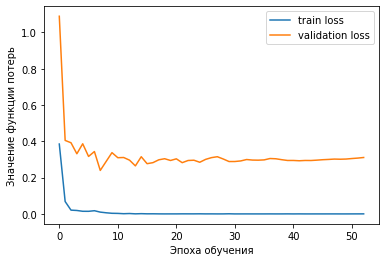

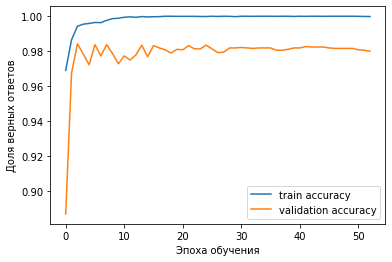

In [17]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [18]:
model.evaluate(X_test, y_test)

3742/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.20816405141057973, 0.98369855]

In [19]:
preds = model.predict(X_test)

print("Test data evaluation:")
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

         cat       0.97      1.00      0.98      1803
         dog       1.00      0.97      0.98      1939

    accuracy                           0.98      3742
   macro avg       0.98      0.98      0.98      3742
weighted avg       0.98      0.98      0.98      3742



In [20]:
old_weights = model.get_weights()

In [21]:
del model
K.clear_session()

model = make_model()
model.set_weights(old_weights)
model.save("cat_dogs_with_InceptionResNetV2_WITHOUT_OPTIMIZER.hdf5")

In [22]:
model.evaluate(X_test, y_test)

3742/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.20816405141057973, 0.98369855]

In [23]:
preds = model.predict(X_test)

print("Test data evaluation:")
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

         cat       0.97      1.00      0.98      1803
         dog       1.00      0.97      0.98      1939

    accuracy                           0.98      3742
   macro avg       0.98      0.98      0.98      3742
weighted avg       0.98      0.98      0.98      3742



In [24]:
import os

In [26]:
print("cat_dogs_with_InceptionResNetV2.hdf5 file size: %.3f Megabytes" % (os.stat("cat_dogs_with_InceptionResNetV2.hdf5").st_size / 1024 / 1024))

cat_dogs_with_InceptionResNetV2.hdf5 file size: 321.795 Megabytes


In [27]:
print("cat_dogs_with_InceptionResNetV2_WITHOUT_OPTIMIZER.hdf5 file size: %.3f Megabytes" % (os.stat("cat_dogs_with_InceptionResNetV2_WITHOUT_OPTIMIZER.hdf5").st_size / 1024 / 1024))

cat_dogs_with_InceptionResNetV2_WITHOUT_OPTIMIZER.hdf5 file size: 246.753 Megabytes
